In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import torch
from solutions.machine_learning_introduction.feed_forward import TwoLayerNet, train_model
import torchvision
from torchvision import transforms
import os
import math
from matplotlib import pyplot as plt

In [19]:
if torch.cuda.is_available():
    print('Compatible GPU available, using CUDA.')
    device = 'cuda'
else:
    print('No compatible GPU available. Using CPU.')
    device = 'cpu'

Compatible GPU available, using CUDA.


In [20]:
# You might need to change this path, depending on your directory structure and current working directory
control_folder = 'solutions/machine_learning_introduction/control_values'
assert os.path.isdir(control_folder), 'Folder for control values not found. Please check your path.'

# Introduction to Machine Learning

In this section, we wilil implement a simple two-layer fully-connected Neural Network and apply it to the MNIST digit classification task we performed before in the tensor introduction.

For that, we will first implement some layers (affine linear, sigmoid and relu) and then assemble those layers into a classifier. 

The code for the layers will be structured into two methods: a `forward` and a `backward` method. The `forward` method will receive the input tensor and the layer's parameters and will return the output and a cache of all the values necessary for backpropagation. The `backward` method will receive the upstream gradient and the cache from the forward pass and will compute the downstream gradient and the gradients of the layer's parameters. The functions will be in the following format:

In [21]:
def layer_forward(x, W):
    # Calculation of out depends on the layer formulation
    out = ...
    # Necessary values depend on the layer formulation
    cache = (x, out)
    return out, cache

def layer_backward(dout, cache):
    x, out = cache
    dx = ...
    # Gradients of the parameters, if the layer has any
    dW = ...
    return dx, dW

We will start with `affine_forward` and `affine_backward`. Head over to `feed_forward.py` and implement the forward and backward pass. Use the following notebook cells to validate your implementation.

In [22]:
from solutions.machine_learning_introduction.feed_forward import affine_forward

# Check for affine_forward

N = 3
c_in = 16
c_out = 10

x = torch.linspace(-4, 4, N*c_in).reshape((N, c_in))
W = torch.linspace(-4, 4, c_in*c_out).reshape((c_out, c_in))
b = torch.linspace(-4, 4, c_out)

with torch.no_grad():
    out, cache = affine_forward(x, W, b)

expected_result = torch.load(f'{control_folder}/affine_forward_out.pt')

assert torch.allclose(out, expected_result)


In [23]:
from solutions.machine_learning_introduction.feed_forward import affine_backward

# Check for affine_backward

N = 3
c_in = 16
c_out = 10

dout = torch.linspace(-4, 4, N*c_out).reshape(N, c_out)

with torch.no_grad():
    dx, dW, db = affine_backward(dout, cache)

expected_dx = torch.load(f'{control_folder}/affine_backward_dx.pt')
expected_dW = torch.load(f'{control_folder}/affine_backward_dW.pt')
expected_db = torch.load(f'{control_folder}/affine_backward_db.pt')

assert torch.allclose(dx, expected_dx)
assert torch.allclose(dW, expected_dW)
assert torch.allclose(db, expected_db)

Next, implement `relu_forward` and `relu_backward`. We will use ReLU as the activation function for the hidden layer. Run the following code cells to check your implementation.

In [24]:
from solutions.machine_learning_introduction.feed_forward import relu_forward

# Check for relu_forward

N = 5
c = 10
x = torch.linspace(-4, 4, N*c).reshape((N, c))

with torch.no_grad():
    out, cache = relu_forward(x)

expected_result = torch.load(f'{control_folder}/relu_forward_out.pt')

assert torch.allclose(expected_result, out)

In [25]:
from solutions.machine_learning_introduction.feed_forward import relu_backward

# Check for relu_backward

N = 5
c = 10
dout = torch.linspace(-4, 4, N*c).reshape((N, c))

with torch.no_grad():
    dx = relu_backward(dout, cache)

expected_result = torch.load(f'{control_folder}/relu_backward_dx.pt')


assert torch.allclose(expected_result, dx)

The last layer we will implement is the sigmoid activation. We will use it to normalize the output of our module to the range [0, 1]. Implement the methods `sigmoid_forward` and `sigmoid_backward`. Use the following code cells to check your implementation.

In [26]:
from solutions.machine_learning_introduction.feed_forward import sigmoid_forward

# Check for sigmoid_forward

N = 5
c = 10
x = torch.linspace(-4, 4, N*c).reshape((N, c))

with torch.no_grad():
    out, cache = sigmoid_forward(x)

expected_result = torch.load(f'{control_folder}/sigmoid_forward_out.pt')

assert torch.allclose(expected_result, out)

In [27]:
from solutions.machine_learning_introduction.feed_forward import sigmoid_backward

# Check for sigmoid_backward

N = 5
c = 10
dout = torch.linspace(-4, 4, N*c).reshape((N, c))

with torch.no_grad():
    dx = sigmoid_backward(dout, cache)

expected_result = torch.load(f'{control_folder}/sigmoid_backward_dx.pt')


assert torch.allclose(expected_result, dx)

## Loss and Accuracy

We will use L2-Loss for our model. This is not the most typical loss for classification (SVM-Loss or Softmax-Loss are more commonly used), but it is easy to understand and works well enough for this simple task. The output of our model will be of shape (N, num_classes). Each entry represents the certainty for this digit. The optimal output for an image labeled as a 2 would then be (omitting the batch dimension):

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0] 

This is called one-hot encoding. You can use `nn.functional.one_hot` for the operation.

Head over to `feed_forward.py` and implement `l2_loss`. Check your implementation with the following code cell.

In [28]:
from solutions.machine_learning_introduction.feed_forward import l2_loss

# Check for l2_loss

N = 5
num_classes = 12
y_pred = torch.load(f'{control_folder}/l2_loss_y_pred.pt')
y_label = torch.load(f'{control_folder}/l2_loss_y_label.pt')

with torch.no_grad():
    loss, grad = l2_loss(y_pred, y_label)

expected_loss = torch.load(f'{control_folder}/l2_loss_loss_value.pt')
expected_grad = torch.load(f'{control_folder}/l2_loss_grad.pt')

assert loss.shape == expected_loss.shape
assert grad.shape == expected_grad.shape
assert torch.allclose(loss, expected_loss)
assert torch.allclose(grad, expected_grad)




As our last method before going on to the classifier itself, we will implement `calculate_accuracy`. It will be used to calculate the training and validation accuracy during model training. Check your code with the following cell.

In [29]:
from solutions.machine_learning_introduction.feed_forward import calculate_accuracy

N = 20
num_classes = 4
inp = torch.zeros((0,))
out = torch.load(f'{control_folder}/calculate_accuracy_out.pt')
labels = torch.load(f'{control_folder}/calculate_accuracy_labels.pt')

class _DummyModel:
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def forward(self, x):
        return out, None
model = _DummyModel(num_classes)

acc = calculate_accuracy(model, inp, labels)

assert torch.allclose(acc, torch.tensor([0.2]))
        

## Building the Model

For the classification, we will build a two-layer feed-forward neural network. The architecture will be the following:

(N, d) - Affine - (N, d_hidden) - ReLu - Affine - (N, num_classes) - Sigmoid

The bracketed expressions note the shape of the inputs and outputs to the affine layers. The last layer is a sigmoid layer, so that the outputs are normalized between 0 and 1.

The two affine layers require parameters (weights and biases). Implement the `__init__` method in the class TwoLayerNet and initialize the weights and biases as following:
- Initialize both biases with zeros.
- Initialize the weight of the first layer normally distributed with std sqrt(2 / c_in)
- Initialize the weight of the second layer normally distributed with std sqrt(2 / (c_in + c_out))

where c_in and c_out are the input and output dimensions of the layers respectively.

The first variant is called He initialization and is mostly used for layers with ReLU activation, the second is called Xavier Normal and is primarly used for sigmoid and tanh activations. This choice of initialization tries to keep the variance of the output similar to the variance of the input. Proper initializations are crucial to avoid gradient explosion or gradient vanishing. This is particularly important for training deeper networks, and the effect can be mitigated by introducing batch normalization or layer normalization.

However, we don't want to focus too much on initialization right. Implement the `__init__` method using the values above and test your code with the following cell. Name your weights 'W1', 'b1', 'W2', and 'b2'.

In [30]:
from solutions.machine_learning_introduction.feed_forward import TwoLayerNet

inp_dim = 100
hidden_dim = 50
out_dim = 40

model = TwoLayerNet(inp_dim, hidden_dim, out_dim)

assert set(model.params.keys()) == {'W1', 'b1', 'W2', 'b2'}

for key, param in model.params.items():
    if key == 'W1':
        correct_std = 0.1414213562373095
        assert abs(torch.std(param).item() - correct_std) / correct_std < 7e-2
    elif key == 'W2':
        correct_std = 0.14907119849998599
        assert abs(torch.std(param).item() - correct_std) / correct_std < 7e-2
    elif 'b' in key:
        assert torch.allclose(param, torch.zeros_like(param))


        

Next, implement the forward pass of the model. Like the individual layers, it should return the output and a cache object, which will just be a tuple of the caches of all the layers. Check your implementation with the following cell.

In [31]:
old_params = {key: param.clone() for key, param in model.params.items()}

N = 5
inp_dim = 100
hidden_dim = 50
out_dim = 40

inp = torch.linspace(-2, 2, inp_dim*N).reshape((N, inp_dim))

for key, param in model.params.items():
    model.params[key] = torch.linspace(-2, 2, torch.numel(param)).reshape(param.shape)

with torch.no_grad():
    out, _ = model.forward(inp)

for key in model.params.keys():
    model.params[key] = old_params[key]
    

expected_result = torch.load(f'{control_folder}/model_forward_out.pt')

assert torch.allclose(out, expected_result)



Now implement the backward pass. This will involve calling the backward passes of the individual layers in reverse order. Check your code with the following cell. Save the gradients of the parameters in the `grads` dictionary. Make sure you use the same keys you used for the parameters.

In [32]:
old_params = {key: param.clone() for key, param in model.params.items()}

N = 5
inp_dim = 100
hidden_dim = 50
out_dim = 40

inp = torch.linspace(-2, 2, inp_dim*N).reshape((N, inp_dim))
dout = torch.linspace(-2, 2, out_dim*N).reshape((N, out_dim))

for key, param in model.params.items():
    model.params[key] = torch.linspace(-2, 2, torch.numel(param)).reshape(param.shape)

with torch.no_grad():
    out, cache = model.forward(inp)
    model.backward(dout, cache)

expected_grads = torch.load(f'{control_folder}/model_backward_grads.pt')

for key, grad in model.grads.items():
    assert torch.allclose(grad, expected_grads[key]), f'Gradient for parameter {key} incorrect.'


## Training the Classifier

We will implement a simple training loop and fit our model to the MNIST dataset of handwritten digits. First, we will load the dataset in.

In [33]:

# --- Load and Prepare MNIST Dataset ---
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])  

# Download and split into training and validation sets
train_set = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
validation_set = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

# Load all training and validation images and labels
train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set))
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=len(validation_set))

train_images, train_labels = next(iter(train_loader))
validation_images, validation_labels = next(iter(validation_loader))


In [34]:
print(train_images.shape, train_labels.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([60000])


Instead of considering the image as a two-dimensional entity, we will flatten it so that it is one large feature vector.

In [36]:
##########################################################################
# TODO: Flatten the train and validation images.                         #
##########################################################################

# Replace "pass" statement with your code
pass

##########################################################################
#               END OF YOUR CODE                                         #
##########################################################################

assert train_images.shape == (60000, 784)
assert validation_images.shape == (10000, 784)

Build a TwoLayerNet with input and output dimensions fitting to our task. You can choose the hidden dimension, 64 might be a good start.

In [37]:
model = None

##########################################################################
# TODO: Initialize the TwoLayerNet by choosing the dimensions correctly. #
##########################################################################

# Replace "pass" statement with your code
pass

##########################################################################
#               END OF YOUR CODE                                         #
##########################################################################

Use the following code cell to transfer the data and parameters to a GPU for training, if you have a compatible GPU available.

In [38]:
train_images = train_images.to(device)
train_labels = train_labels.to(device)
validation_images = validation_images.to(device)
validation_labels = validation_labels.to(device)

for key, param in model.params.items():
    model.params[key] = param.to(device)

Now implement the method `train_model`. Instructions for the implementation are placed in the TODO message in the method.
Run the following code cell to execute your training. Depending on your chosen hidden_dim, batch_size and learning_rate, you can expect accuracies above 95%.

In [40]:
with torch.no_grad():
    train_model(model, train_images, train_labels, validation_images, validation_labels, n_epochs=10, learning_rate=1e-2)

Starting with epoch 0...
    Train accuracy: 0.91
    Validation accuracy: 0.92

Starting with epoch 1...
    Train accuracy: 0.93
    Validation accuracy: 0.93

Starting with epoch 2...
    Train accuracy: 0.94
    Validation accuracy: 0.94

Starting with epoch 3...
    Train accuracy: 0.95
    Validation accuracy: 0.95

Starting with epoch 4...
    Train accuracy: 0.95
    Validation accuracy: 0.95

Starting with epoch 5...
    Train accuracy: 0.96
    Validation accuracy: 0.95

Starting with epoch 6...
    Train accuracy: 0.96
    Validation accuracy: 0.96

Starting with epoch 7...
    Train accuracy: 0.96
    Validation accuracy: 0.96

Starting with epoch 8...
    Train accuracy: 0.97
    Validation accuracy: 0.96

Starting with epoch 9...
    Train accuracy: 0.97
    Validation accuracy: 0.96



We achieved quite a high accuracy, particularly compared to our baseline of about 82% from using the mean images as templates. It's also notable that there is close to no gap between the training and validation accuracy. That means we didn't overfit the dataset. This wouldn't have been probably anyway, given the low capacity and small size of our model. 

Let's take a look at some of the images we failed to classify correctly.

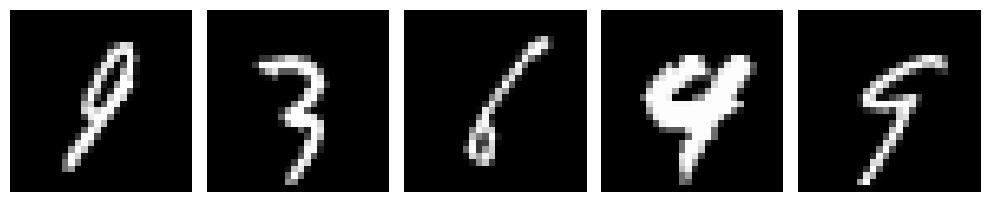

Labels: tensor([9, 3, 6, 4, 9], device='cuda:0')
Guess: tensor([1, 7, 1, 9, 5], device='cuda:0')


In [41]:
def plot_images(images, nrows=None, ncols=None):
    if ncols is None:
        ncols = min(len(images), 5)
    if nrows is None:
        nrows = math.ceil(len(images) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))

    for i, ax in enumerate(axes.flat):
        image = images[i].squeeze()
        ax.imshow(image, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
with torch.no_grad():
    validation_out, _ = model.forward(validation_images)
    validation_guess = torch.argmax(validation_out, dim=-1)

    wrong_images = validation_images[validation_guess != validation_labels]
    N_wrong = wrong_images.shape[0]
    wrong_images = wrong_images.reshape((N_wrong, 28, 28))
    wrong_labels = validation_labels[validation_guess != validation_labels]
    wrong_guess = validation_guess[validation_guess != validation_labels]

    wrong_images = wrong_images.to('cpu')

perm = torch.randperm(N_wrong)
plot_images(wrong_images[perm[:5]])
print(f'Labels: {wrong_labels[perm[:5]]}')
print(f'Guess: {wrong_guess[perm[:5]]}')



Some of the missclassifications you see might be really hard to tell, as the dataset contains some ambiguous numbers. Some of them might be easy to classify correctly for you as a human. A feedforward neural network isn't the typical architecture for image classification anyway (even though it worked quite well on these size-normalized, centered images). Architectures that are more typically used are Convolutional Neural Networks and Image Transformers. We won't go into ConvNets in this series, but Image Transformers use the same attention mechanism we will implement in the next chapter as their core building block. 

To close off with this section, let's see how we could have avoided doing the backwards calculation by ourselves with `torch.autograd`. Carefully read through the following notebook we implemented for you.

In [ ]:
# Select a batch for training
data_batch = train_images[:16,...]
label_batch = train_labels[:16, ...]

# Zero out the gradients for all parameters and telling torch, they need a gradient
for key, param in model.params.items():
    param.grad = None
    param.requires_grad = True

# The forward pass goes along as usual
out, cache = model.forward(data_batch)

# Loss calculation 
loss, dout = l2_loss(out, label_batch)

# This is the pytorch magic: When calling backward on a single-element tensor,
#  it will automatically compute the gradients for all tensors in the computational graph
#  that require a gradient calculation.
loss.backward()

# Collecting the gradients calculated by autograd
torch_grads = {
    key: param.grad for key, param in model.params.items()
}

# Computing our own gradients for comparison
with torch.no_grad():
    model.backward(dout, cache)

# Comparing our gradients with the model's gradients. The relative errors should be around 1e-6 

    for key, grad in model.grads.items():
        rel_err = (grad-torch_grads[key]).abs() / (1e-8+torch_grads[key].abs())
        mean_rel_err = torch.mean(rel_err).item()
        print(f'Relative error on {key}: {mean_rel_err}')




## Conclusion

In this chapter, we have seen the basic mechanism of building and training a neural network. This section was kept really short, as we won't have to deal with training ourselves in our AlphaFold implementation. Training a model as big as AlphaFold would be infeasible on personal machines, and renting compute on this scale is really expensive. Also, our code won't be close to being optimized enough to allow for training it (even though theoretically, with torch.autograd, our implementation of the forward pass would allow us to do the full training). 

Still, there is so much more to discover in machine learning and training neural networks. For example, our training using stochastic gradient descent would typically be replaced by another optimization like Nesterov Momentum or Adam (both have the effect of putting more emphasis on weight changes that are consistent, and that aren't just reverted in the next batch). AlphaFold for example uses Adam for optimization during training. Also, there are many more layers that are really useful. The AlphaFold architecture for example uses dropout (randomly setting a set of values to zero during training, no effect during inference) and LayerNormalization (shifting and scaling the activations of a layer so that they have mean 0 and std 1). 

We won't implement any more of these here, but there are great resources online. If you still have Machine-Learning energy left after or during this series, check out the CS231n course from Stanford. The assignments from their offering in 2023 are freely available [here](https://github.com/cs231n/cs231n.github.io/tree/master/assignments/2023). You can find lecture slides and videos from previous offerings online. Assignment 1 is basically an improved and more extensive version of this notebook. More recent videos with similar topics were uploaded by Justin Johnson from the University of Michigan [here](https://youtube.com/playlist?list=PL5-TkQAfAZFbzxjBHtzdVCWE0Zbhomg7r&si=fCgVj8DhU1kTidVN). Both are great for getting a deeper introduction to machine learning, specifically Computer Vision.

For now, we will leave it here and go on to our next, shorter chapter, where we will implement our first primitive for AlphaFold: MultiHeadAttention